# Travelling Salesman Problem 

## Global code

In [41]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from itertools import combinations
import networkx as nx
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm

In [42]:
countries = ['Russia', 'Italy', 'Vanuatu', 'China', 'US']

def init(country):
    global CITIES, DIST_MATRIX
    # Load cities data
    CITIES = pd.read_csv(f'cities/{country}.csv'.lower(), header=None, names=['name', 'lat', 'lon'])

    # Create distance matrix
    DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
    for c1, c2 in combinations(CITIES.itertuples(), 2):
        DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km

## Helper Functions

In [43]:
# Compute the total length of a tour
def compute_tour_distance(path, distance_matrix):
    total_distance = 0.0
    for i in range(len(path) - 1):
        city_from = path[i]
        city_to = path[i + 1]
        total_distance += distance_matrix[city_from][city_to]
    return total_distance

# Print each step of the tour
def print_tour(path, distance_matrix, cities):
    for i in range(len(path) - 1):
        city_from = path[i]
        city_to = path[i + 1]
        distance = distance_matrix[city_from][city_to]
        
        print(f"step {i+1}: {cities.at[city_from,'name']} -> {cities.at[city_to,'name']} ({distance:.2f}km)")

# Plot the Generation vs. Total Distance
def plot_total_distances(generations, total_distances, country):
    plt.figure(figsize=(10, 6))
    plt.plot(generations, total_distances, marker='o', color='b', linestyle='-', linewidth=1, markersize=5)
    plt.title(f"Generation vs. Total Distance in {country}")
    plt.xlabel("# Generation")
    plt.ylabel("Total Distance (km)")
    plt.grid(True)
    plt.show()
    

## Greedy Approaches
In the follow three different algorithms based on a greedy approach are presented.

### Minimum Spanning Tree (MST)

In [44]:
# Function to compute TSP path using Minimum Spanning Tree
def mst_tsp(distance_matrix):
    # Create a graph from distance matrix
    G = nx.Graph()
    num_cities = len(distance_matrix)
    
    # Add edges to the graph with distances as weights
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            G.add_edge(i, j, weight=distance_matrix[i][j])
    
    # Generate MST
    mst = nx.minimum_spanning_tree(G, weight='weight')
    
    # Get a preorder traversal of the MST (DFS)
    preorder_nodes = list(nx.dfs_preorder_nodes(mst, source=0))
    
    # Generate TSP path by visiting nodes in preorder
    tsp_tour = preorder_nodes + [preorder_nodes[0]]  # Return to starting city
    
    return tsp_tour


#### Run MST

In [45]:
# Run MST-based TSP approximation for each country
for country in countries:
    init(country)
    tsp_tour = mst_tsp(DIST_MATRIX)
    tot_distance = compute_tour_distance(tsp_tour, DIST_MATRIX)
    print(f"MST-based TSP Tour in {country}")
    print(f"Result: Found a path of {len(tsp_tour) - 1} steps, total length {tot_distance:.2f}km\n")
    # Print each step of the tour
    print_tour(tsp_tour, DIST_MATRIX, CITIES)
    print("\n\n")

MST-based TSP Tour in Russia
Result: Found a path of 167 steps, total length 44627.76km

step 1: Abakan -> Krasnoyarsk (276.58km)
step 2: Krasnoyarsk -> Achinsk (161.71km)
step 3: Achinsk -> Bratsk (693.41km)
step 4: Bratsk -> Angarsk (439.00km)
step 5: Angarsk -> Irkutsk (34.88km)
step 6: Irkutsk -> Ulan‐Ude (238.28km)
step 7: Ulan‐Ude -> Chita (402.25km)
step 8: Chita -> Blagoveshchensk (1002.31km)
step 9: Blagoveshchensk -> Khabarovsk (588.32km)
step 10: Khabarovsk -> Komsomolsk‐na‐Amure (274.21km)
step 11: Komsomolsk‐na‐Amure -> Yuzhno‐Sakhalinsk (582.17km)
step 12: Yuzhno‐Sakhalinsk -> Ussuriysk (909.51km)
step 13: Ussuriysk -> Artyom (50.78km)
step 14: Artyom -> Vladivostok (34.21km)
step 15: Vladivostok -> Nakhodka (87.36km)
step 16: Nakhodka -> Yakutsk (2146.61km)
step 17: Yakutsk -> Magadan (1173.79km)
step 18: Magadan -> Petropavlovsk‐Kamchatskiy (875.16km)
step 19: Petropavlovsk‐Kamchatskiy -> Novokuznetsk (4553.60km)
step 20: Novokuznetsk -> Prokopyevsk (30.63km)
step 21: P

### Custom Nearest Neighbor Algorithm 

In [46]:
# Custom Nearest Neighbor TSP algorithm with bidirectional expansion
def custom_nn_tsp(distance_matrix):
    num_cities = len(distance_matrix)
    visited = [False] * num_cities
    
    start_city = 0
    path = [start_city, start_city]
    visited[start_city] = True

    index = 0
    
    # Alternate adding the closest city from both ends towards the middle
    while not np.all(visited):
        # Expand from the front
        nearest_cities_front = np.argsort(distance_matrix[path[index]])
        nearest_to_front = next(
            city for city in nearest_cities_front if not visited[city]
        )
        path.insert(index + 1, nearest_to_front)  # Insert into next position
        visited[nearest_to_front] = True

        # Check if we filled all cities
        if np.all(visited):
            break

        # Expand from the back
        nearest_cities_back = np.argsort(distance_matrix[path[-(index+1)]])
        nearest_to_back = next(
            city for city in nearest_cities_back if not visited[city]
        )
        path.insert(-(index+1), nearest_to_back)  # Insert into next position
        visited[nearest_to_back] = True

        index += 1

    return path


#### Run Custom NNA

In [47]:
# Run custom NNA-based TSP algorithm for each country
for country in countries:
    init(country)
    tsp_tour = custom_nn_tsp(DIST_MATRIX)
    tot_distance = compute_tour_distance(tsp_tour, DIST_MATRIX)
    print(f"Custom Nearest Neighbor Algorithm TSP Tour in {country}")
    print(f"Result: Found a path of {len(tsp_tour) - 1} steps, total length {tot_distance:.2f}km\n")
    # Print each step of the tour
    print_tour(tsp_tour, DIST_MATRIX, CITIES)
    print("\n\n")

Custom Nearest Neighbor Algorithm TSP Tour in Russia
Result: Found a path of 167 steps, total length 46976.31km

step 1: Abakan -> Krasnoyarsk (276.58km)
step 2: Krasnoyarsk -> Achinsk (161.71km)
step 3: Achinsk -> Kemerovo (296.59km)
step 4: Kemerovo -> Tomsk (147.60km)
step 5: Tomsk -> Seversk (14.97km)
step 6: Seversk -> Biysk (454.70km)
step 7: Biysk -> Kyzyl (636.95km)
step 8: Kyzyl -> Angarsk (658.94km)
step 9: Angarsk -> Irkutsk (34.88km)
step 10: Irkutsk -> Ulan‐Ude (238.28km)
step 11: Ulan‐Ude -> Chita (402.25km)
step 12: Chita -> Bratsk (899.62km)
step 13: Bratsk -> Nizhnevartovsk (1537.90km)
step 14: Nizhnevartovsk -> Surgut (173.64km)
step 15: Surgut -> Nefteyugansk (43.14km)
step 16: Nefteyugansk -> Noyabrsk (278.28km)
step 17: Noyabrsk -> Novyy Urengoy (328.30km)
step 18: Novyy Urengoy -> Norilsk (612.52km)
step 19: Norilsk -> Berezniki (1844.90km)
step 20: Berezniki -> Izhevsk (353.17km)
step 21: Izhevsk -> Naberezhnye Chelny (140.93km)
step 22: Naberezhnye Chelny -> Alm

### Classic Nearest Neighbor Algorithm 

In [48]:
def nearest_neighbor_tsp(distance_matrix):
    num_cities = len(distance_matrix)
    visited = np.zeros(num_cities, dtype=bool)  # Boolean array to track visited cities

    start_city = 0
    visited[start_city] = True
    path = [start_city]
    current_city = start_city

    for _ in range(num_cities - 1):
        # Find the nearest unvisited city 
        distances = distance_matrix[current_city]  # Get distances from current city
        nearest_cities = np.where(~visited)[0]  # Indices of unvisited cities
        
        # Find the nearest city among unvisited ones
        nearest_city_index = nearest_cities[np.argmin(distances[nearest_cities])]
        
        # Move to the nearest city
        path.append(nearest_city_index)
        visited[nearest_city_index] = True
        current_city = nearest_city_index

    # Return to the starting city to complete the tour
    path.append(start_city)

    return path

#### Run Classic NNA

In [49]:
# Run classic NN-based TSP algorithm for each country
for country in countries:
    init(country)
    tsp_tour = nearest_neighbor_tsp(DIST_MATRIX)
    tot_distance = compute_tour_distance(tsp_tour, DIST_MATRIX)
    print(f"Classic Nearest Neighbor Algorithm TSP Tour in {country}")
    print(f"Result: Found a path of {len(tsp_tour) - 1} steps, total length {tot_distance:.2f}km\n")
    # Print each step of the tour
    print_tour(tsp_tour, DIST_MATRIX, CITIES)
    print("\n\n")

Classic Nearest Neighbor Algorithm TSP Tour in Russia
Result: Found a path of 167 steps, total length 42334.16km

step 1: Abakan -> Krasnoyarsk (276.58km)
step 2: Krasnoyarsk -> Achinsk (161.71km)
step 3: Achinsk -> Kemerovo (296.59km)
step 4: Kemerovo -> Leninsk‐Kuznetskiy (74.76km)
step 5: Leninsk‐Kuznetskiy -> Prokopyevsk (91.87km)
step 6: Prokopyevsk -> Novokuznetsk (30.63km)
step 7: Novokuznetsk -> Biysk (187.38km)
step 8: Biysk -> Barnaul (132.82km)
step 9: Barnaul -> Novosibirsk (194.50km)
step 10: Novosibirsk -> Tomsk (206.90km)
step 11: Tomsk -> Seversk (14.97km)
step 12: Seversk -> Rubtsovsk (613.13km)
step 13: Rubtsovsk -> Omsk (647.47km)
step 14: Omsk -> Tobolsk (475.40km)
step 15: Tobolsk -> Tyumen (200.98km)
step 16: Tyumen -> Kurgan (189.69km)
step 17: Kurgan -> Kopeysk (236.87km)
step 18: Kopeysk -> Chelyabinsk (14.72km)
step 19: Chelyabinsk -> Miass (87.20km)
step 20: Miass -> Zlatoust (33.88km)
step 21: Zlatoust -> Pervouralsk (194.64km)
step 22: Pervouralsk -> Yekate

## Genetic Algorithms (GA)

#### Global code GA

In [50]:
@dataclass
class Individual:
    genome: list
    fitness: float = None

    def calculate_fitness(self):
        total_distance = 0
        for i in range(len(self.genome) - 1):
            total_distance += DIST_MATRIX[self.genome[i], self.genome[i + 1]]
        total_distance += DIST_MATRIX[self.genome[-1], self.genome[0]]  # Return to start
        self.fitness = 1/total_distance  # Fitness is inverse of distance --> note that -total_distance doesn't work with roulette wheel selection (due to negative values)

In the follow implementations of several parent selection, crossover and mutation strategies are proposed. Heuristically, it's possible to notice that the best approaches to use for the **Travelling Salesman Problem** are tournament selection along with order crossover (OX) and inversion mutation. 

#### Parent Selection Strategies implementations

In [51]:
# Parent Selection Strategies
def uniform_selection(population):
    return random.choice(population)

def roulette_wheel_selection(population):
    total_fitness = sum(ind.fitness for ind in population)
    pick = random.uniform(0, total_fitness)
    current = 0
    for ind in population:
        current += ind.fitness
        if current > pick:
            return ind

def fitness_proportional_selection(population):
    fitnesses = np.array([ind.fitness for ind in population])
    probabilities = fitnesses / fitnesses.sum()
    return np.random.choice(population, p=probabilities)

def rank_based_selection(population):
    ranked_population = sorted(population, key=lambda ind: ind.fitness)
    ranks = np.arange(1, len(population) + 1)
    probabilities = ranks / ranks.sum()
    return np.random.choice(ranked_population, p=probabilities)

def tournament_selection(population, tournament_size=3):
    candidates = random.sample(population, tournament_size)
    return max(candidates, key=lambda ind: ind.fitness)


#### Crossover Strategies implementations

In [52]:
# Crossover Strategies
def order_crossover(parent1, parent2):
    size = len(parent1.genome)
    start, end = sorted(random.sample(range(1, size), 2))
    child_genome = [None] * size
    child_genome[start:end] = parent1.genome[start:end]
    
    current_index = 0
    for gene in parent2.genome:
        if gene not in child_genome:
            while child_genome[current_index] is not None:
                current_index += 1
            child_genome[current_index] = gene
            
    return Individual(genome=child_genome)

def partially_mapped_crossover(parent1, parent2):
    size = len(parent1.genome)
    start, end = sorted(random.sample(range(1, size), 2))
    
    child_genome1 = [None] * size
    child_genome2 = [None] * size

    # Create the mapping
    for i in range(start, end):
        child_genome1[i] = parent1.genome[i]
        child_genome2[i] = parent2.genome[i]

    mapping1 = {parent1.genome[i]: parent2.genome[i] for i in range(start, end)}
    mapping2 = {parent2.genome[i]: parent1.genome[i] for i in range(start, end)}

    # Fill in the rest
    for i in range(size):
        if child_genome1[i] is None:
            gene = parent2.genome[i]
            while gene in mapping2:
                gene = mapping2[gene]
            child_genome1[i] = gene

        if child_genome2[i] is None:
            gene = parent1.genome[i]
            while gene in mapping1:
                gene = mapping1[gene]
            child_genome2[i] = gene

    return Individual(genome=child_genome1), Individual(genome=child_genome2)

def cycle_crossover(parent1, parent2):
    size = len(parent1.genome)
    child_genome1 = [None] * size
    child_genome2 = [None] * size

    # Initialize the starting point
    cycle_start = 0
    while None in child_genome1:
        if child_genome1[cycle_start] is None:
            current = cycle_start
            while child_genome1[current] is None:
                child_genome1[current] = parent1.genome[current]
                current = parent2.genome.index(parent1.genome[current])
            # Fill child_genome2 with parent2 genes
            for i in range(size):
                if child_genome1[i] is None:
                    child_genome2[i] = parent2.genome[i]
    
    return Individual(genome=child_genome1), Individual(genome=child_genome2)

def inver_over_crossover(parent1, parent2):
    size = len(parent1.genome)
    start, end = sorted(random.sample(range(1, size), 2)) # Start from index 1 to avoid first city
    child_genome = parent1.genome[:start] + \
                   parent2.genome[start:end] + \
                   parent1.genome[end:]
    
    # Fix the child genome to ensure no cities are repeated
    child_genome = list(dict.fromkeys(child_genome))  # Remove duplicates while preserving order
    assert child_genome[0] == 0  # First city must be the starting city
    while len(child_genome) < size:
        for city in parent1.genome:
            if city not in child_genome:
                child_genome.append(city)
    return Individual(genome=child_genome)

#### Mutation Strategies implementations

In [53]:
# Mutation Strategies
def scramble_mutation(individual, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        start, end = sorted(random.sample(range(1, len(individual.genome)), 2))
        segment = individual.genome[start:end]
        random.shuffle(segment)
        individual.genome[start:end] = segment
    return individual

def insert_mutation(individual, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        idx1, idx2 = random.sample(range(1, len(individual.genome)), 2)
        gene = individual.genome.pop(idx1)
        individual.genome.insert(idx2, gene)
    return individual

def inversion_mutation(individual, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        # Select two indices to invert
        idx1, idx2 = random.sample(range(1, len(individual.genome)), 2) #ensuring we don't choose index 0
        # Invert the section between the two indices
        if idx1 > idx2:
            idx1, idx2 = idx2, idx1
        individual.genome[idx1:idx2+1] = reversed(individual.genome[idx1:idx2+1])
    return individual

### Genetic Algorithm implementation
The algorithm is implemented in such a way as to allow choosing the parental selection, crossover and mutation strategies to be used. 

In [ ]:
# Main Genetic Algorithm for TSP
def genetic_algorithm_tsp(num_individuals=100, num_generations=1000,
                          parent_selection_strategy='tournament',
                          crossover_strategy='order',
                          mutation_strategy='inversion',
                          tournament_size=3, mutation_rate=0.1, country='Italy'):
    
    # Initialize population with city 0 fixed and others randomly selected
    population = []
    for _ in range(num_individuals):
        unique_cities = random.sample(range(1, len(CITIES)), len(CITIES) - 1)
        genome = [0] + unique_cities  # Start with city 0
        population.append(Individual(genome=genome))

    #append the 3 greedy solutions (obtained from previous algorithms) to the population to ensure that the good enough solution is not missed
    tour_greedy_1 = [int(i) for i in nearest_neighbor_tsp(DIST_MATRIX)]
    tour_greedy_1.pop()
    tour_greedy_2 = [int(i) for i in custom_nn_tsp(DIST_MATRIX)]
    tour_greedy_2.pop()
    tour_greedy_3 = [int(i) for i in mst_tsp(DIST_MATRIX)]
    tour_greedy_3.pop()
    population.append(Individual(genome=tour_greedy_1))
    population.append(Individual(genome=tour_greedy_2))
    population.append(Individual(genome=tour_greedy_3))

    # Evaluate initial population
    for ind in population:
        ind.calculate_fitness()

    
    # Initialize lists to store generations and total distances to plot finally the data 
    generations = []
    total_distances = []

    for generation in tqdm(range(num_generations)):
        new_population = []

        while len(new_population) < num_individuals:

            # Select parents based on chosen strategy
            if parent_selection_strategy == 'uniform':
                parent1 = uniform_selection(population)
                parent2 = uniform_selection(population)
            elif parent_selection_strategy == 'roulette':
                parent1 = roulette_wheel_selection(population)
                parent2 = roulette_wheel_selection(population)
            elif parent_selection_strategy == 'fitness-proportional':
                parent1 = fitness_proportional_selection(population)
                parent2 = fitness_proportional_selection(population)
            elif parent_selection_strategy == 'rank':
                parent1 = rank_based_selection(population)
                parent2 = rank_based_selection(population)
            elif parent_selection_strategy == 'tournament':
                parent1 = tournament_selection(population, tournament_size)
                parent2 = tournament_selection(population, tournament_size)
            else:
                raise ValueError("Invalid parent selection strategy")

            # Crossover to create offspring based on chosen strategy
            if crossover_strategy == 'inver-over':
                child = inver_over_crossover(parent1, parent2)
            elif crossover_strategy == 'order':
                child = order_crossover(parent1, parent2)
            elif crossover_strategy == 'partially-mapped':
                child1, child2 = partially_mapped_crossover(parent1, parent2)
                child = child1 if np.random.rand() < 0.5 else child2
            elif crossover_strategy == 'cycle':
                child1, child2 = cycle_crossover(parent1, parent2)
                child = child1 if np.random.rand() < 0.5 else child2
            else:
                raise ValueError("Invalid crossover strategy")

            # Mutate offspring based on chosen strategy
            if mutation_strategy == 'scramble':
                child = scramble_mutation(child, mutation_rate)
            elif mutation_strategy == 'insert':
                child = insert_mutation(child, mutation_rate)
            elif mutation_strategy == 'inversion':
                child = inversion_mutation(child, mutation_rate)
            else:
                raise ValueError("Invalid mutation strategy")

            child.calculate_fitness()
            new_population.append(child)

        # Replace population with new population
        population = new_population

        # Print the best fitness at each generation
        best_fitness = max(ind.fitness for ind in population)
        if (generation + 1) % 100 == 0:
            '''print(f'Generation {generation + 1}: Current total distance = {1/best_fitness:.2f}km') 
            print(f'Best individual: {max(population, key=lambda ind: ind.fitness).genome}\n')'''
            # Store data for plotting
            generations.append(generation + 1)
            total_distances.append(1/best_fitness)
            
    # Return the best individual found
    best_individual = max(population, key=lambda ind: ind.fitness)

    
    # Plot the Generation vs. Total Distance
    plot_total_distances(generations, total_distances, country)

    return best_individual

#### Run the genetic algorithm, specifying the strategies

100%|██████████| 4000/4000 [01:18<00:00, 50.99it/s]


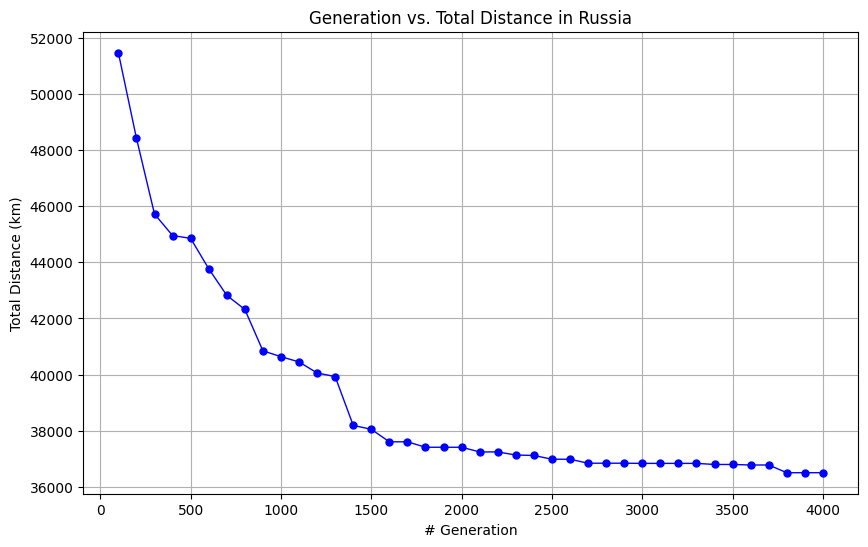

Genetic Algorithm TSP Tour in Russia
Result: Found a path of 167 steps, total length 36498.24km

step 1: Abakan -> Krasnoyarsk (276.58km)
step 2: Krasnoyarsk -> Achinsk (161.71km)
step 3: Achinsk -> Kemerovo (296.59km)
step 4: Kemerovo -> Leninsk‐Kuznetskiy (74.76km)
step 5: Leninsk‐Kuznetskiy -> Prokopyevsk (91.87km)
step 6: Prokopyevsk -> Novokuznetsk (30.63km)
step 7: Novokuznetsk -> Biysk (187.38km)
step 8: Biysk -> Barnaul (132.82km)
step 9: Barnaul -> Tomsk (358.18km)
step 10: Tomsk -> Seversk (14.97km)
step 11: Seversk -> Novosibirsk (211.49km)
step 12: Novosibirsk -> Rubtsovsk (407.28km)
step 13: Rubtsovsk -> Omsk (647.47km)
step 14: Omsk -> Tobolsk (475.40km)
step 15: Tobolsk -> Tyumen (200.98km)
step 16: Tyumen -> Kurgan (189.69km)
step 17: Kurgan -> Kamensk‐Uralskiy (237.85km)
step 18: Kamensk‐Uralskiy -> Yekaterinburg (95.20km)
step 19: Yekaterinburg -> Pervouralsk (40.19km)
step 20: Pervouralsk -> Nizhniy Tagil (112.49km)
step 21: Nizhniy Tagil -> Berezniki (249.01km)
step

100%|██████████| 4000/4000 [00:12<00:00, 325.73it/s]


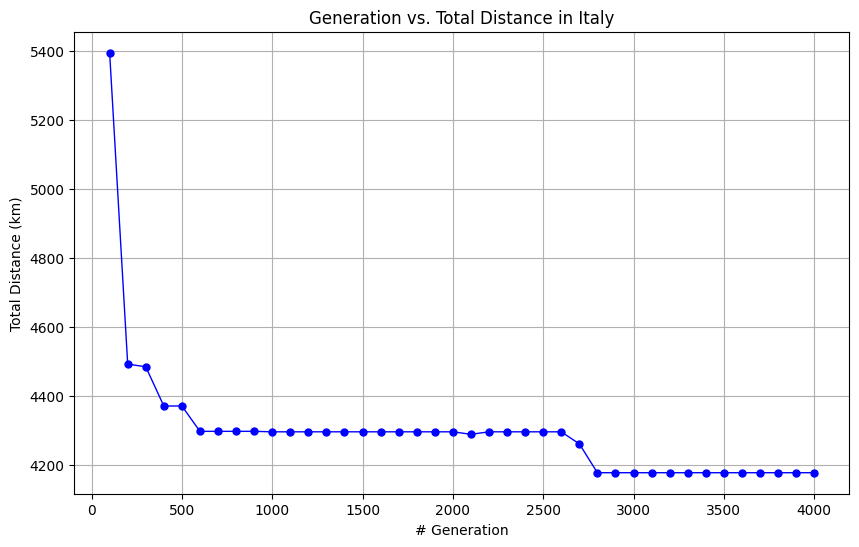

Genetic Algorithm TSP Tour in Italy
Result: Found a path of 46 steps, total length 4176.28km

step 1: Ancona -> Rimini (90.60km)
step 2: Rimini -> Forlì (46.72km)
step 3: Forlì -> Ravenna (26.46km)
step 4: Ravenna -> Ferrara (66.67km)
step 5: Ferrara -> Vicenza (79.10km)
step 6: Vicenza -> Padua (30.13km)
step 7: Padua -> Venice (36.07km)
step 8: Venice -> Trieste (115.09km)
step 9: Trieste -> Bolzano (209.68km)
step 10: Bolzano -> Trento (49.94km)
step 11: Trento -> Verona (71.85km)
step 12: Verona -> Brescia (61.42km)
step 13: Brescia -> Bergamo (46.02km)
step 14: Bergamo -> Monza (33.92km)
step 15: Monza -> Milan (14.51km)
step 16: Milan -> Novara (43.07km)
step 17: Novara -> Turin (84.46km)
step 18: Turin -> Genoa (123.19km)
step 19: Genoa -> Piacenza (92.66km)
step 20: Piacenza -> Parma (57.65km)
step 21: Parma -> Reggio nell'Emilia (26.94km)
step 22: Reggio nell'Emilia -> Modena (23.94km)
step 23: Modena -> Bologna (37.29km)
step 24: Bologna -> Prato (70.67km)
step 25: Prato -> F

100%|██████████| 4000/4000 [00:04<00:00, 894.17it/s]


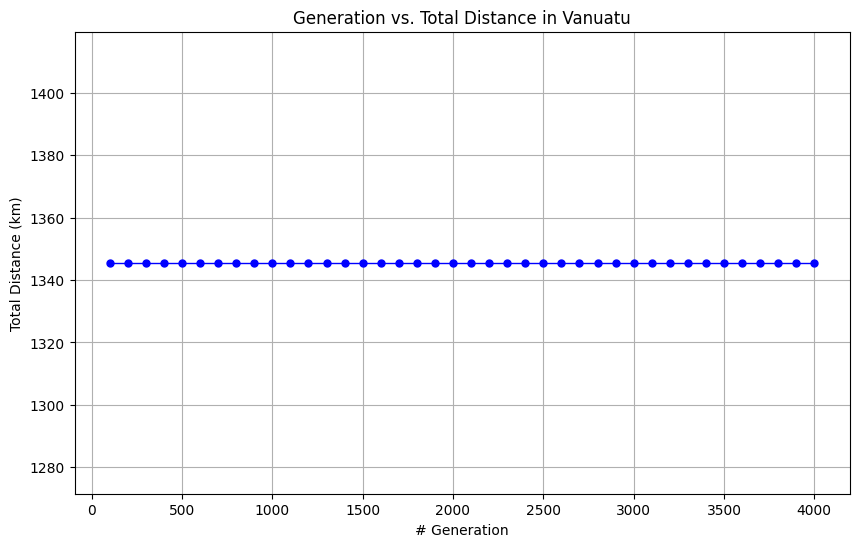

Genetic Algorithm TSP Tour in Vanuatu
Result: Found a path of 8 steps, total length 1345.54km

step 1: Isangel -> Vila (223.00km)
step 2: Vila -> Lakatoro (206.74km)
step 3: Lakatoro -> Norsup (2.46km)
step 4: Norsup -> Luganville (67.09km)
step 5: Luganville -> Port Olry (52.02km)
step 6: Port Olry -> Sola (141.25km)
step 7: Sola -> Longana (165.49km)
step 8: Longana -> Isangel (487.49km)





100%|██████████| 4000/4000 [23:02<00:00,  2.89it/s]


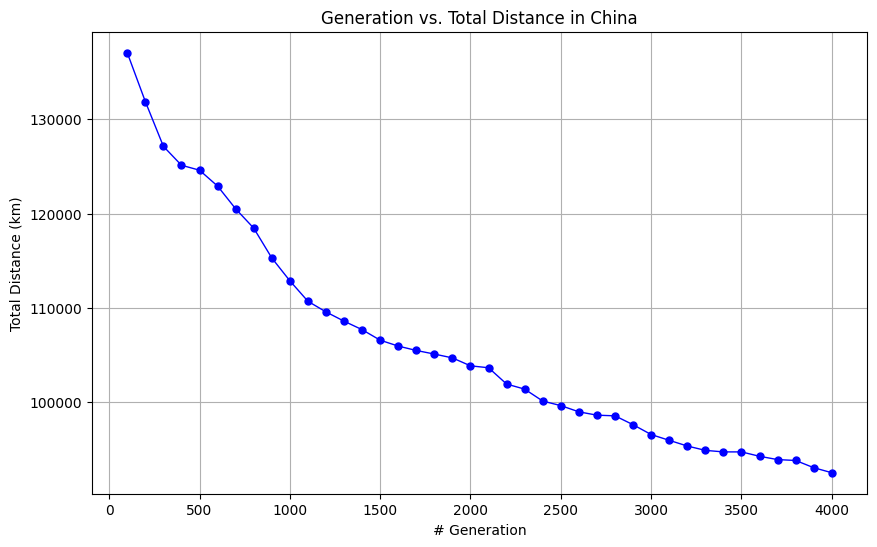

Genetic Algorithm TSP Tour in China
Result: Found a path of 726 steps, total length 92513.15km

step 1: Acheng -> Harbin (33.60km)
step 2: Harbin -> Yushu (102.49km)
step 3: Yushu -> Shulan (55.57km)
step 4: Shulan -> Jishu (17.91km)
step 5: Jishu -> Jilin city (50.81km)
step 6: Jilin city -> Jiutai (65.06km)
step 7: Jiutai -> Dehui (43.68km)
step 8: Dehui -> Changchun (78.49km)
step 9: Changchun -> Siping (113.35km)
step 10: Siping -> Liaoyuan (71.76km)
step 11: Liaoyuan -> Meihekou (60.38km)
step 12: Meihekou -> Panshi (55.16km)
step 13: Panshi -> Huadian (56.40km)
step 14: Huadian -> Jiaohe (96.49km)
step 15: Jiaohe -> Dunhua (82.15km)
step 16: Dunhua -> Longjing (117.08km)
step 17: Longjing -> Yanji (14.70km)
step 18: Yanji -> Tumen (26.45km)
step 19: Tumen -> Huichun (46.09km)
step 20: Huichun -> Ningan (179.31km)
step 21: Ningan -> Hailin (26.54km)
step 22: Hailin -> Mudanjiang (18.30km)
step 23: Mudanjiang -> Muleng (81.67km)
step 24: Muleng -> Hengshan (43.08km)
step 25: Hengsh

100%|██████████| 4000/4000 [04:44<00:00, 14.05it/s]


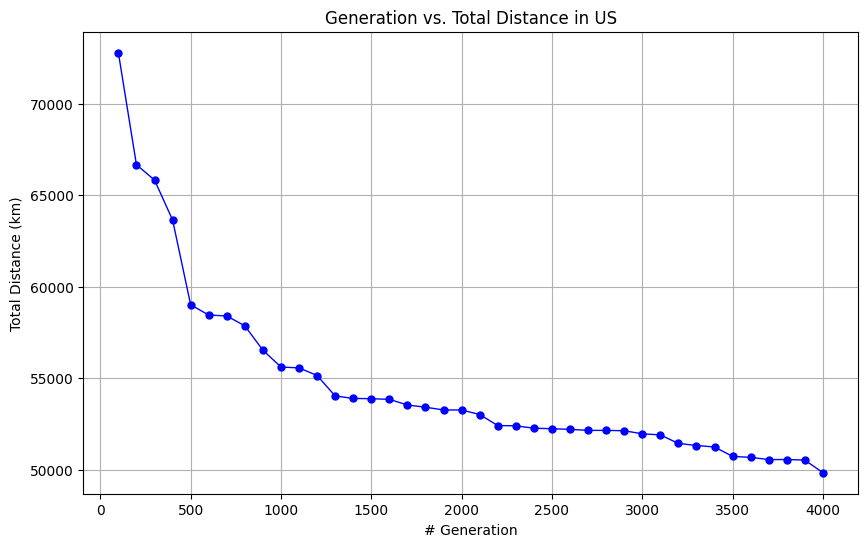

Genetic Algorithm TSP Tour in US
Result: Found a path of 326 steps, total length 49842.71km

step 1: Abilene -> Denton (257.31km)
step 2: Denton -> Lewisville (23.92km)
step 3: Lewisville -> Carrollton (10.02km)
step 4: Carrollton -> Jackson (631.66km)
step 5: Jackson -> Columbus (502.53km)
step 6: Columbus -> Macon (120.37km)
step 7: Macon -> Atlanta (126.00km)
step 8: Atlanta -> Sandy Springs (19.36km)
step 9: Sandy Springs -> Athens (92.34km)
step 10: Athens -> Augusta (136.61km)
step 11: Augusta -> Tallahassee (382.94km)
step 12: Tallahassee -> Gainesville (203.06km)
step 13: Gainesville -> Spring Hill (134.16km)
step 14: Spring Hill -> Clearwater (60.05km)
step 15: Clearwater -> Saint Petersburg (26.94km)
step 16: Saint Petersburg -> Tampa (28.18km)
step 17: Tampa -> Riverview (23.56km)
step 18: Riverview -> Cape Coral (134.47km)
step 19: Cape Coral -> Lehigh Acres (35.86km)
step 20: Lehigh Acres -> Pembroke Pines (145.27km)
step 21: Pembroke Pines -> Miramar (7.46km)
step 22: Mir

In [55]:
# Run the Genetic Algorithm with specified strategies for each country
for country in countries:
    init(country)
    best_solution = genetic_algorithm_tsp(
        num_individuals=100, 
        num_generations=4000,
        parent_selection_strategy='tournament',  # desired strategy among ['uniform', 'roulette', 'fitness-proportional', 'rank', 'tournament']
        crossover_strategy='order',                # desired strategy among ['inver-over', 'order', 'partially-mapped', 'cycle']
        mutation_strategy='inversion',              #  desired strategy among ['scramble', 'insert', 'inversion']
        country=country
    )


    best_solution.genome.append(best_solution.genome[0])  # Return to starting city
    tot_distance = compute_tour_distance(best_solution.genome, DIST_MATRIX)




    print(f"Genetic Algorithm TSP Tour in {country}")
    print(f"Result: Found a path of {len(best_solution.genome) - 1} steps, total length {tot_distance:.2f}km\n")
    #Print each step of the tour
    print_tour(best_solution.genome, DIST_MATRIX, CITIES)
    print("\n\n")
